In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rcParams['axes.facecolor']='white'
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
# Prepare lists to store the flattened images and labels
flattened_images = []
labels = []

# Loop over each file in the directory
for filename in os.listdir("Images"):
    file_path = os.path.join("Images", filename)
    with Image.open(file_path) as img:
        original_dimensions = (img.size[1], img.size[0])
        flattened_img = np.array(img).flatten()
        flattened_images.append(flattened_img)
        # Extract the class label from the filename
        # Example filename: yaleB01_P00A+000E+00.png
        # Extract '01' from 'yaleB01', which is the subject ID
        label = filename.split('_')[0]
        label = label[5:7]
        labels.append(label)

# Convert lists to numpy arrays
image_matrix = np.array(flattened_images)
label_array = np.array(labels)

print("Image matrix shape:", image_matrix.shape)
print("Labels array shape:", label_array.shape)
print("Original image dimensions:", original_dimensions)

Image matrix shape: (2414, 32256)
Labels array shape: (2414,)
Original image dimensions: (192, 168)


In [3]:
# Unique classes in the dataset
unique_classes = np.unique(labels)

# Initialize lists to hold the split results
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

train_indices = []
test_indices = []

for cls in unique_classes:
    indices = np.where(label_array == cls)[0]
    train_idx, test_idx = train_test_split(indices, train_size=0.75, random_state=42, shuffle=True)
    train_indices.extend(train_idx)
    test_indices.extend(test_idx)

# Use the indices to split both the original and transformed datasets
X_train = image_matrix[train_indices]
X_test = image_matrix[test_indices]
y_train = label_array[train_indices]
y_test = label_array[test_indices]

In [4]:
#First apply PCA to reduce the dimensionality of the dataset
num_pca_components = X_train.shape[0] // 5
pca = PCA(n_components=num_pca_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
n_classes = len(np.unique(y_train))

#First find mean vector of each class
mean_vectors = []
for cls in unique_classes:
    cls_indices = np.where(y_train == cls)[0]
    cls_mean = np.mean(X_train_pca[cls_indices], axis=0)
    mean_vectors.append(cls_mean)
    
#Now find the within-class scatter matrix
Sw = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(y_train == cls)[0]
    cls_scatter = np.zeros((num_pca_components, num_pca_components))
    for idx in cls_indices:
        row = X_train_pca[idx].reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        cls_scatter += np.dot((row - mean_vec), (row - mean_vec).T)
    Sw += cls_scatter
    
#Now find the between-class scatter matrix
overall_mean = np.mean(X_train_pca, axis=0)
Sb = np.zeros((num_pca_components, num_pca_components))
for cls, mean_vec in zip(unique_classes, mean_vectors):
    cls_indices = np.where(y_train == cls)[0]
    n_cls = len(cls_indices)
    mean_vec = mean_vec.reshape(-1, 1)
    overall_mean = overall_mean.reshape(-1, 1)
    Sb += n_cls * np.dot((mean_vec - overall_mean), (mean_vec - overall_mean).T)
    
#Now find Fisherfaces as the eigenvectors corresponding to the positive eigenvalues of Sw^(-1)Sb such that eigenvalues are sorted in descending order
eigenvalues, eigenvectors = np.linalg.eigh(np.dot(np.linalg.inv(Sw), Sb))
#Flip the eigenvectors and eigenvalues to sort them in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

valid_eigenvectors = eigenvectors[:, np.where(eigenvalues > 0)[0]]
valid_eigenvalues = eigenvalues[np.where(eigenvalues > 0)]
invalid_eigenvectors = eigenvectors[:, np.where(eigenvalues <= 0)[0]]
invalid_eigenvalues = eigenvalues[np.where(eigenvalues <= 0)]

fisherfaces = np.dot(valid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))
invalid_fisherfaces = np.dot(invalid_eigenvectors.T, pca.components_).reshape((-1, original_dimensions[0], original_dimensions[1]))

In [5]:
print("Number of valid Fisherfaces:", fisherfaces.shape[0])
print("Number of invalid Fisherfaces:", invalid_fisherfaces.shape[0])

Number of valid Fisherfaces: 37
Number of invalid Fisherfaces: 324


In [6]:
def apply_fisherfaces(X, y, num_pca_components):
    n_classes = len(np.unique(y))
    num_lda_components = 20 if n_classes > 20 else n_classes - 1
    
    pca = PCA(n_components=num_pca_components)
    X_pca = pca.fit_transform(X)
    
    lda = LDA(n_components=num_lda_components, solver='eigen')
    X_fisher = lda.fit_transform(X_pca, y)

    return X_fisher, pca, lda

In [7]:
X_train_fisher, pca, lda = apply_fisherfaces(X_train, y_train, num_pca_components = num_pca_components)
X_test_fisher = lda.transform(pca.transform(X_test))

In [8]:
print("Reduced training set shape:", X_train_fisher.shape)
print("Reduced test set shape:", X_test_fisher.shape)
print("Fisherfaces shape:", fisherfaces.shape)

Reduced training set shape: (1809, 20)
Reduced test set shape: (605, 20)
Fisherfaces shape: (37, 192, 168)


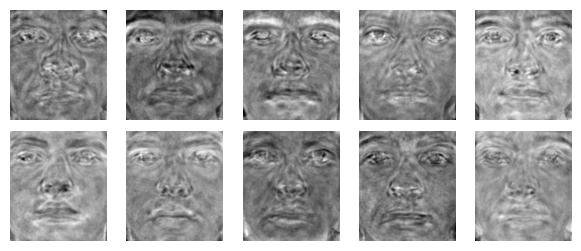

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12, 3))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(fisherfaces[i], cmap='gray')
    ax.axis('off')
plt.subplots_adjust(wspace=-0.75, hspace=0.1)
plt.show()

In [10]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot = True, fmt='d', cmap = 'Blues', xticklabels = unique_classes, yticklabels = unique_classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return classifier

In [11]:
logistic_classifier = LogisticRegression(random_state = 42, C = 0.005, max_iter = 250)
svm_classifier = SVC(kernel = 'linear', random_state = 42, C = 0.001, max_iter = 250)

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

          01       1.00      1.00      1.00        16
          02       1.00      1.00      1.00        16
          03       0.89      1.00      0.94        16
          04       1.00      0.94      0.97        16
          05       1.00      1.00      1.00        16
          06       1.00      1.00      1.00        16
          07       0.89      1.00      0.94        16
          08       1.00      1.00      1.00        16
          09       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.97        15
          15       1.00      0.81      0.90        16
          16       1.00      1.00      1.00        16
          17       1.00      1.00      1.00        16
          18       1.00      1.00      1.00

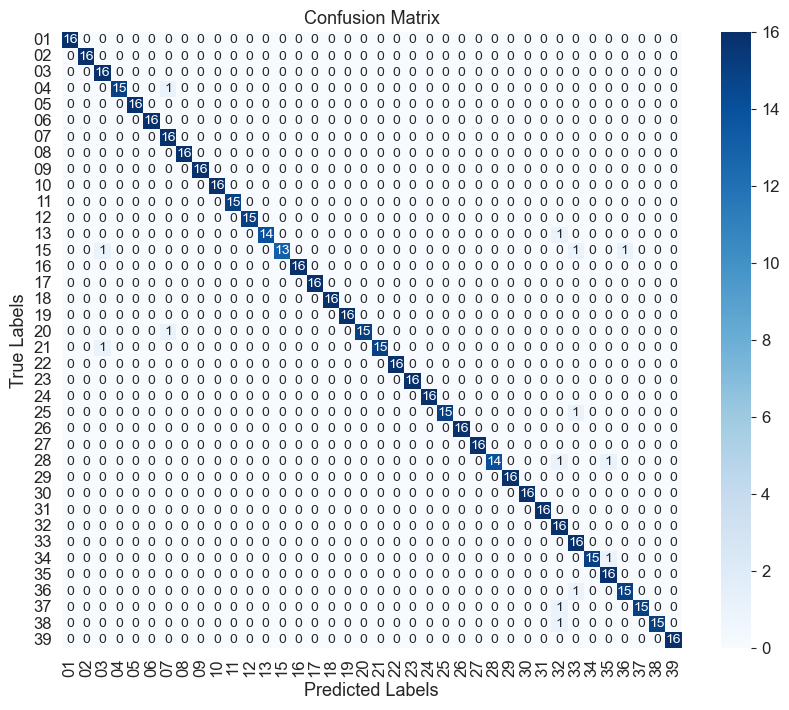

LogisticRegression(C=0.005, max_iter=250, random_state=42)

In [12]:
evaluate_model(logistic_classifier, X_train_fisher, y_train, X_test_fisher, y_test)

Accuracy: 0.96
Classification Report:
              precision    recall  f1-score   support

          01       1.00      1.00      1.00        16
          02       1.00      0.88      0.93        16
          03       0.84      1.00      0.91        16
          04       1.00      1.00      1.00        16
          05       1.00      1.00      1.00        16
          06       1.00      1.00      1.00        16
          07       1.00      1.00      1.00        16
          08       1.00      0.88      0.93        16
          09       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        16
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.97        15
          15       1.00      0.81      0.90        16
          16       1.00      0.88      0.93        16
          17       1.00      1.00      1.00        16
          18       1.00      1.00      1.00

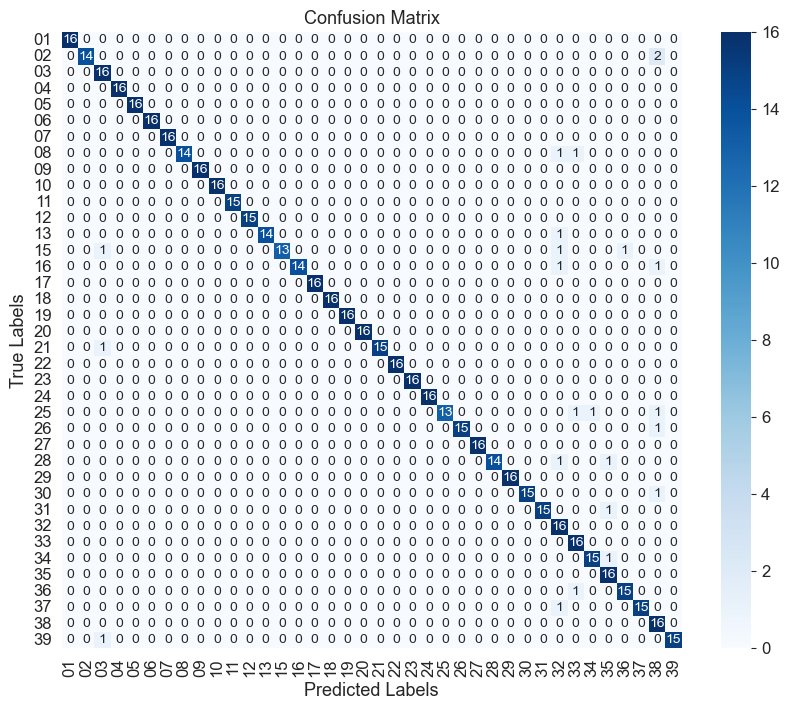

SVC(C=0.001, kernel='linear', max_iter=250, random_state=42)

In [13]:
evaluate_model(svm_classifier, X_train_fisher, y_train, X_test_fisher, y_test)